# 电容质检任务

本实验首先完成任务二和任务三为上游，提取的特征值作为任务一的输入并实现 SVC 分类任务。

##### 测试集 test1 的测试代码块在底部，可以运行模型文件直接输出结果。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import imutils
from skimage import measure
import os
from tqdm import tqdm

查看图片矩阵。

In [4]:
def visualize(img, format=None):
    if img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(img, format)
    plt.show()

将结果写入 txt 文件。

In [5]:
def write_res2(src, x, y, r, name):
    with open(src, 'a') as f: 
        line = str(name) + '\t' + str((x, y)) + '\t' + str(r) + '\n'
        f.write(line)

In [6]:
def write_res3(src, x1, y1, r1, x2, y2, r2, name):
    with open(src, 'a') as f: 
        line = str(name) + '\t' + str((x1, y1)) + '\t' + str(r1) + '\t' + str((x2, y2)) + '\t' + str(r2) + '\n'
        f.write(line)

## 任务二
定位电容位置，标出电容圆周。

- 通过经典的 Canny 算法实现可调节的边缘检测。
    - dp 累加器分辨率与图像分辨率的反比，dp 获取越大，累加器数组越小。
    - minDist 检测到的圆的中心（x, y）坐标之间的最小距离。如果 minDist 太小，则可能导致检测到多个相邻的圆。如果 minDist 太大，则可能导致很多圆检测不到。
    - param1 用于处理边缘检测的梯度值。
    - param2 HOUGH_GRADIENT 方法的累加器阈值。阈值越小，检测到的圈子越多。

    - minRadius 半径的最小大小。
    - maxRadius 半径的最大大小。

- Hough 算法的圆检测基于 Canny 算法进一步检测出圆形形状，并确定圆心和半径。

In [7]:
def circle_detect(src, out_src=None, g=3, show_pic=False):
    origin_img = cv2.imread(src)
    origin_img = origin_img[800:1300, 900:1400]
    gray_image = cv2.cvtColor(origin_img, cv2.COLOR_BGR2GRAY)
    blur_image = cv2.GaussianBlur(gray_image, (g, g), 0)

    Img = cv2.Canny(blur_image, 75, 150)
    circle = cv2.HoughCircles(Img, cv2.HOUGH_GRADIENT, 1, 100, param1=100, param2=25, minRadius=170, maxRadius=210) 
   
    if circle is not None:
        circle = np.uint16(np.around(circle[0][0]))
        cv2.circle(origin_img, (circle[0], circle[1]), circle[2], (255, 0, 0), 5) 
        cv2.circle(origin_img, (circle[0], circle[1]), 2, (255, 0, 0), 10)  
        if show_pic:
            plt.imshow(origin_img)
            plt.show()
        if out_src:
            cv2.imwrite(out_src, origin_img)
        return circle[0], circle[1], circle[2]
    else:
        return 0, 0, 0

选取图片试验结果并可视化。

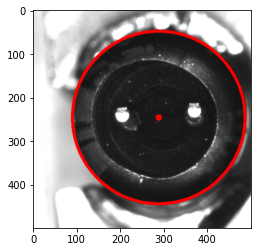

In [6]:
x, y, r = circle_detect('./test2/1 (4).bmp', show_pic=True)

遍历文件夹中所有图片，在 txt 文件中输出结果。

In [7]:
files = os.listdir('./test2')
for f in tqdm(files):
    if '.bmp' in f:
        x, y, r = circle_detect('./test2/' + f, './result2/' + f)
        write_res2('result2.txt', x, y, r, f)

100%|██████████| 142/142 [00:58<00:00,  2.44it/s]


## 任务三
利用管脚亮度和周围像素点有显著差异定位管脚位置，并标出电容管脚。
- 强度阈值检测
- 调用 imutils.grab_contours 获取梯度较大边缘
- 检测亮点

In [8]:
def pin_detect(src, out_src=None, g=15, show_pic=False):
    Image = cv2.imread(src)
    Image = Image[920:1100, 1000:1320]
    gray = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (g, g), 0)
    thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=4)
    thresh = cv2.dilate(thresh, None, iterations=9)

    labels = measure.label(thresh, background=0, connectivity=2)
    mask = np.zeros(thresh.shape, dtype='uint8')

    for label in np.unique(labels):
        if label == 0:
            continue
            
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        if numPixels > 300:
            mask = cv2.add(mask, labelMask)
            
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    if len(cnts) > 0:
        cnts = contours.sort_contours(cnts)[0]

        cXlist = []
        cYlist = []
        rlist = []
        cnts = cnts[:2]

        for (i, c) in enumerate(cnts):
            (x, y, w, h) = cv2.boundingRect(c)
            ((cX, cY), r) = cv2.minEnclosingCircle(c)

            cXlist.append(int(cX))
            cYlist.append(int(cY))
            rlist.append(int(r))

            cv2.circle(Image, (int(cX), int(cY)), int(r), (255, 0, 0), 5)

        if show_pic:
            plt.imshow(Image)
            plt.show()
        if out_src:  
            cv2.imwrite(out_src, Image)
        return cXlist, cYlist, rlist
    else:
        return [0], [0], [0], 

选取图片试验结果并可视化。

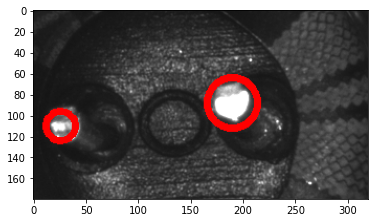

In [15]:
cXlist, cYlist, rlist = pin_detect('./test2/9 (5).bmp', show_pic=True)

遍历文件夹中所有图片，在 txt 文件中输出结果。

In [14]:
files = os.listdir('./test3')
for f in tqdm(files):
    if '.bmp' in f:
        cXlist, cYlist, rlist = pin_detect('./test3/' + f, './result3/' + f)
        write_res3('result3.txt', cXlist[0], cYlist[0], rlist[0], cXlist[1], cYlist[1], rlist[1], f)

100%|██████████| 142/142 [01:06<00:00,  2.13it/s]


## 任务一
实现传统机器学习 SVM 实现二分类。

In [14]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn import inspection
import pickle

构建正例和负例数据。

In [17]:
X_pos = []
X_neg = []
Y_pos = []
Y_neg = []

读入不合格数据和标签到变量。使用任务二和任务三实现的函数进行特征值提取，作为样本数据。

In [18]:
files = os.listdir('./unqualified')
for f in tqdm(files):
    if '.bmp' in f:
        x, y, r = circle_detect('./unqualified/' + f)
        cXlist, cYlist, rlist = pin_detect('./unqualified/' + f, './result4/' + f)
        if len(cXlist) < 2:
            X_neg.append([x, y, r, cXlist[0], 0, cYlist[0], 0, rlist[0], 0])
        else:
            X_neg.append([x, y, r, cXlist[0], cXlist[1], cYlist[0], cYlist[1], rlist[0], rlist[1]])
        Y_neg.append(1)

100%|██████████| 489/489 [03:53<00:00,  2.09it/s]


可以看到，不合格样本有 488 个，且每个样本有 9 个特征值，对应上游任务提取的半径和坐标连续值。

In [19]:
len(Y_neg), X_neg[0]

(488, [286, 252, 200, 112, 270, 135, 127, 23, 24])

读入合格数据和标签到变量。使用任务二和任务三实现的函数进行特征值提取，M作为样本数据。

In [20]:
files = os.listdir('./qualified')
for f in tqdm(files):
    if '.bmp' in f:
        x, y, r = circle_detect('./qualified/' + f)
        cXlist, cYlist, rlist = pin_detect('./qualified/' + f)
        if len(cXlist) < 2:
            X_pos.append([x, y, r, cXlist[0], 0, cYlist[0], 0, rlist[0], 0])
        else:
            X_pos.append([x, y, r, cXlist[0], cXlist[1], cYlist[0], cYlist[1], rlist[0], rlist[1]])
        Y_pos.append(0)

100%|██████████| 3353/3353 [27:13<00:00,  2.05it/s]  


可以看到，合格样本有 3352 个，且每个样本有 9 个特征值，对应上游任务提取的半径和坐标连续值。

In [21]:
len(Y_pos), X_pos[0]

(3352, [282, 240, 200, 101, 261, 126, 118, 23, 24])

将合格与不合格数据和标签序列分别拼接，之后打乱顺序，得到 X_ 和 Y_ 数据集。

In [22]:
X = np.concatenate((X_pos, X_neg))
Y = np.concatenate((Y_pos, Y_neg))

数据集打乱，分出训练集和测试集，比例为 0.9 和 0.1。

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

实例化迭代器，实现 K 折验证，这里取 K=10。
SVM 分类器采用 rbf 内核，gamma 和 C 。

In [24]:
cv = StratifiedKFold(n_splits=10)
clf = svm.SVC(kernel='rbf', gamma=0.0001, C=1000, probability=True, random_state=0)

进行训练，对每折做出 ROC 曲线。

10it [00:24,  2.48s/it]


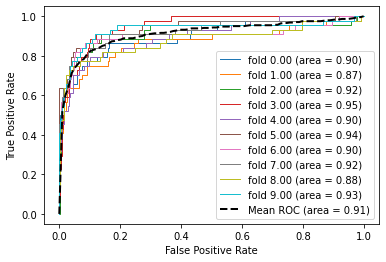

In [25]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
cnt = 0

for i, (train, test) in tqdm(enumerate(cv.split(X_train, Y_train))):
    cnt += 1
    probas_ = clf.fit(X_train[train], Y_train[train]).predict_proba(X_train[test])
    fpr, tpr, _ = roc_curve(Y_train[test], probas_[:, 1]) # 伪正例、真正例

    mean_tpr += np.interp(mean_fpr, fpr, tpr) # 累计每次循环的总值后面求平均值
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, lw=1, label='fold {0:.2f} (area = {1:.2f})'.format(i, roc_auc))

mean_tpr /= cnt
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = {0:.2f})'.format(mean_auc), lw=2) 
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

对模型进行测试，打印出评估分数结果。

In [26]:
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       336
           1       0.79      0.62      0.70        48

    accuracy                           0.93       384
   macro avg       0.87      0.80      0.83       384
weighted avg       0.93      0.93      0.93       384



更进一步，网格搜索实现 SVM 自动调参，调用 GridSearchCV 对 SVC 中的重要参数进行调参并取得最优解。

In [27]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']

for score in scores:
    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=8, scoring='%s_macro' % score)
    clf.fit(X_train, Y_train)
  
    print("Best parameters set found on development set:", clf.best_params_)
     
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
  
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  
    y_pred = clf.predict(X_test)
    print(classification_report(Y_test, y_pred))

Best parameters set found on development set: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.900 (+/-0.040) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.917 (+/-0.070) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.903 (+/-0.041) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.902 (+/-0.055) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.877 (+/-0.027) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.897 (+/-0.046) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.853 (+/-0.066) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.885 (+/-0.040) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       336
           1       0.95      0.44      0.60        48

    accuracy                           0.93       384
   macro avg       0.94      0.72      0.78       384
weighted avg       0.93      0.93      0.91       384

Best parameters set found on development set: {'C': 1000, 'gamma

将分类模型保存到本地。

In [29]:
with open('svm_model.pickle', 'wb') as f: 
    pickle.dump(clf, f)

## 测试 对测试集进行分类并输出二分类结果
请先运行前面的函数定义和所有库引用模块。

读取 test1 文件夹，输出预测结果。0 代表合格，1 代表不合格。

In [33]:
X_test1 = []
y_test1 = []

files = os.listdir('./test1')
for f in tqdm(files):
    if '.bmp' in f:
        x, y, r = circle_detect('./test1/' + f)
        cXlist, cYlist, rlist = pin_detect('./test1/' + f)
        if len(cXlist) < 2:
            X_test1.append([x, y, r, cXlist[0], 0, cYlist[0], 0, rlist[0], 0])
        else:
            X_test1.append([x, y, r, cXlist[0], cXlist[1], cYlist[0], cYlist[1], rlist[0], rlist[1]])

100%|██████████| 79/79 [00:11<00:00,  7.15it/s]


输出合格与不合格样本的比例。

In [34]:
with open('svm_model.pickle', 'rb') as f:  
    clf_load = pickle.load(f)
    y_test1 = clf_load.predict(X_test1)
    print('the percentage of qualified samples:', np.sum(np.where(y_test1, 0, 1)) / len(y_test1))
    print('the percentage of unqualified samples:', np.sum(y_test1) / len(y_test1))

the percentage of qualified samples: 0.8461538461538461
the percentage of unqualified samples: 0.15384615384615385


可以对结果的边界可视化。

In [38]:
X_test1 = np.array(X_test1)
X_test1.shape

(78, 9)

参数列表。
- 0 电容 x 坐标
- 1 电容 y 坐标
- 2 电容半径
- 3 左管脚 x 坐标
- 4 左管脚 y 坐标
- 5 左管脚半径
- 6 右管脚 x 坐标
- 7 右管脚 y 坐标
- 8 右管脚半径

In [60]:
def vis_data(feat1, feat2, feat3):
    with open('svm_model.pickle', 'rb') as f:  
        clf_load = pickle.load(f)
        y_test1 = clf_load.predict(X_test1)
        ax = plt.subplot(projection="3d")
        ax.scatter3D(X_test1[:, feat1], X_test1[:, feat2], X_test1[:, feat3], c=y_test1, s=50, cmap='rainbow')
        ax.set_xlabel("feature1")
        ax.set_ylabel("feature2")
        ax.set_zlabel("feature3")
        ax.view_init(elev=30,azim=30)
        plt.show()

观察分类的电容坐标和半径的分布。

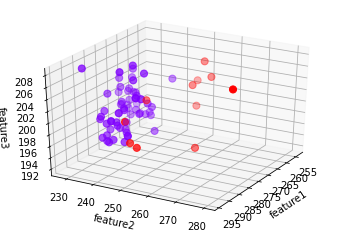

In [61]:
vis_data(0, 1, 2)

检查预测结果 y_test1 的具体值。

In [36]:
y_test1[:10]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])